In [1]:
# """
# predicting a sequence of future prices (`n_steps_out`) instead of just one.

# Benefits of This Approach
# Utilizes Temporal Patterns: The model learns dependencies across multiple future time steps.
# More Robust Predictions: Predicting a sequence captures trends better than single-step predictions.
# Real-World Applicability: Multi-step forecasting is closer to real-world use cases, such as portfolio management.
# """

In [2]:
!pip install -r requirements.txt -q
!pip install ipython-autotime -q

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import math
import matplotlib.pyplot as plt
import joblib
from joblib import Parallel, delayed
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Input, Dense, Dropout, BatchNormalization, Reshape, Flatten, Bidirectional, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam

%matplotlib inline
%load_ext autotime

print("tensorflow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

2024-11-19 16:24:50.781863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 16:24:50.781953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 16:24:50.783813: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 16:24:50.794169: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 16:24:51.967956: W tensorflow/compiler/tf2

tensorflow version: 2.15.0
Num GPUs Available:  1


2024-11-19 16:24:53.757745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-19 16:24:53.804315: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-19 16:24:53.804315: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

True

time: 86.5 ms (started: 2024-11-19 16:24:53 +00:00)


In [4]:
# parameter
# n_steps_in: Number of input time steps
# n_steps_out: Number of days to predict ahead

n_steps_in = 14  
n_steps_out = 5
epochs = 50
batch_size = 32

time: 451 µs (started: 2024-11-19 16:24:53 +00:00)


In [5]:
def load_processed_data(data_dir='processed_data'):
    """
    Load processed DataFrames list and numpy arrays from files
    """
    data_path = Path(data_dir)
    
    # Load list of DataFrames
    with open(data_path / 'processed_dfs.pkl', 'rb') as f:
        processed_dfs = joblib.load(f)
    
    # Load numpy arrays
    values_path = data_path / 'values_array.npy'
    values_list = np.load(values_path, allow_pickle=True)
    
    return processed_dfs, values_list

processed_dfs, values_list = load_processed_data('processed_data')
processed_dfs[0]

Price,Adj Close,Close,High,Low,Open,Volume,RSI,WR,SMA7,SMA14,...,EMA7,EMA25,EMA99,EMA200,MACD,CCI,Upper Band,Lower Band,Ulcer Index,Close Next Day
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-19 00:00:00+00:00,25.937435,28.752501,29.129999,28.670000,29.025000,193146000,38.868505,-58.647164,28.875357,29.083214,...,29.011843,29.811806,30.819353,30.361521,-0.639367,-59.662038,30.115768,28.050661,8.949397,28.162500
2015-08-20 00:00:00+00:00,25.405201,28.162500,28.587500,27.907499,28.520000,274006400,34.842467,-76.661486,28.845357,28.928750,...,28.799508,29.684936,30.766216,30.339640,-0.675706,-101.719165,29.807586,28.049914,8.822285,26.440001
2015-08-21 00:00:00+00:00,23.851353,26.440001,27.975000,26.412500,27.607500,513102000,26.282999,-99.232910,28.506786,28.702321,...,28.209631,29.435326,30.679692,30.300837,-0.833884,-193.641185,30.187027,27.217616,8.940749,25.780001
2015-08-24 00:00:00+00:00,23.255964,25.780001,27.200001,23.000000,23.717501,648825200,23.863926,-60.271513,28.077143,28.496607,...,27.602223,29.154147,30.581698,30.255854,-1.000959,-286.791374,30.611922,26.381293,9.012688,25.934999
2015-08-25 00:00:00+00:00,23.395788,25.934999,27.777500,25.875000,27.777500,414406400,25.595895,-58.056453,27.640715,28.288393,...,27.185417,28.906520,30.488764,30.212860,-1.108087,-175.033141,30.766350,25.810436,9.087065,27.422501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-25 00:00:00+00:00,231.155685,231.410004,233.220001,229.570007,229.740005,38802300,53.621399,-42.696626,233.175714,231.504286,...,232.117849,229.678046,219.220789,207.361942,2.040117,34.671127,237.405189,225.603382,1.664750,233.399994
2024-10-28 00:00:00+00:00,233.143494,233.399994,234.729996,232.550003,233.320007,36087100,56.742652,-32.306559,233.354285,232.049285,...,232.438385,229.964350,219.504373,207.621027,2.033819,76.852796,237.075664,227.022906,1.484857,233.669998


time: 105 ms (started: 2024-11-19 16:24:53 +00:00)


In [6]:
def preprocess_stock_data(values_list, n_steps_in=14, n_steps_out=5, train_split=0.8):
    """
    Preprocess multiple stock datasets for LSTM training.
    
    Args:
        values_list: List of numpy arrays containing stock data with technical indicators
        n_steps_in: Number of lookback days
        n_steps_out: Number of prediction days
        train_split: Train/validation split ratio
        
    Returns:
        tuple: (train_X, train_y, val_X, val_y, global_scaler)
    """
    # 1. Global scaling across all stocks
    global_scaler = MinMaxScaler(feature_range=(0, 1))
    combined_values = np.vstack(values_list)
    scaled_combined = global_scaler.fit_transform(combined_values)
    
    # 2. Split back into individual stocks
    scaled_values_list = []
    start_idx = 0
    for values in values_list:
        scaled_values_list.append(scaled_combined[start_idx:start_idx + len(values)])
        start_idx += len(values)
    
    # 3. Create sequences for each stock
    train_X_list, train_y_list = [], []
    val_X_list, val_y_list = [], []
    
    for scaled_values in scaled_values_list:
        # Remove 'Close Next Day' from features (last column)
        features = scaled_values[:, :-1]  # All columns except the last one
        targets = scaled_values[:, -1]    # Only the last column
        
        # Split into train/validation
        n_train = int(len(features) * train_split)
        
        # Ensure we have enough data for both training and validation
        if n_train <= n_steps_in + n_steps_out:
            print(f"Warning: Stock with {len(features)} samples is too short for meaningful splitting")
            continue
            
        # Split features and targets
        train_features = features[:n_train]
        train_targets = targets[:n_train]
        val_features = features[n_train:]
        val_targets = targets[n_train:]
        
        # Create sequences
        if len(train_features) > n_steps_in + n_steps_out:
            train_X, train_y = create_sequences(train_features, train_targets, n_steps_in, n_steps_out)
            train_X_list.append(train_X)
            train_y_list.append(train_y)
            
        if len(val_features) > n_steps_in + n_steps_out:
            val_X, val_y = create_sequences(val_features, val_targets, n_steps_in, n_steps_out)
            val_X_list.append(val_X)
            val_y_list.append(val_y)
    
    # 4. Combine all sequences
    train_X = np.vstack(train_X_list)
    train_y = np.vstack(train_y_list)
    val_X = np.vstack(val_X_list)
    val_y = np.vstack(val_y_list)
    
    print(f"Training shapes: X={train_X.shape}, y={train_y.shape}")
    print(f"Validation shapes: X={val_X.shape}, y={val_y.shape}")
    print(f"Number of features: {train_X.shape[2]}")
    
    return train_X, train_y, val_X, val_y, global_scaler

def create_sequences(features, targets, n_steps_in, n_steps_out):
    """
    Generate synchronized sequences for LSTM input features and output targets.
    
    Args:
        features: Scaled feature data (numpy array)
        targets: Scaled target data (numpy array)
        n_steps_in: Number of input time steps
        n_steps_out: Number of output time steps
        
    Returns:
        tuple: (X sequences, y sequences)
    """
    X, y = [], []
    
    # Ensure we have enough data for sequence creation
    if len(features) < n_steps_in + n_steps_out:
        raise ValueError("Data length is too short for the specified sequence lengths")
    
    for i in range(len(features) - n_steps_in - n_steps_out + 1):
        # Input sequence (n_steps_in days of all features)
        seq_x = features[i:(i + n_steps_in)]
        # Output sequence (next n_steps_out days of target variable)
        seq_y = targets[(i + n_steps_in):(i + n_steps_in + n_steps_out)]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

train_X, train_y, val_X, val_y, scaler = preprocess_stock_data(values_list, n_steps_in, n_steps_out, train_split=0.8)

Training shapes: X=(34865, 14, 20), y=(34865, 5)
Validation shapes: X=(8474, 14, 20), y=(8474, 5)
Number of features: 20
time: 142 ms (started: 2024-11-19 16:24:53 +00:00)


In [7]:
def create_lstm_model(n_steps_in, n_features, n_steps_out):
    tf.keras.backend.clear_session()
    model = Sequential([
        LSTM(100, activation='relu', input_shape=(n_steps_in, n_features), kernel_initializer='glorot_uniform'),
        Dense(n_steps_out)
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    loss = ['mae']
    model.compile(optimizer=optimizer, loss_weights=[1], loss=loss)
    model.summary()
    
    return model

# Create and train model
model = create_lstm_model(n_steps_in=n_steps_in, n_features=train_X.shape[2], n_steps_out=n_steps_out)

2024-11-19 16:24:54.125378: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-19 16:24:54.125651: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-19 16:24:54.125834: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               48400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 48905 (191.04 KB)
Trainable params: 48905 (191.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
time: 3 s (started: 2024-11-19 16:24:54 +00:00)


In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history = model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=epochs,
    batch_size=batch_size,
    verbose=2,
    shuffle=False
)

Epoch 1/50


2024-11-19 16:24:59.670350: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb9dc010720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-19 16:24:59.670533: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P5000, Compute Capability 6.1
2024-11-19 16:24:59.678994: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-19 16:25:00.452654: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1732033500.575896    4932 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1090/1090 - 26s - loss: 0.0216 - val_loss: 0.0303 - 26s/epoch - 24ms/step
Epoch 2/50
1090/1090 - 21s - loss: 0.0106 - val_loss: 0.0240 - 21s/epoch - 19ms/step
Epoch 3/50
1090/1090 - 21s - loss: 0.0092 - val_loss: 0.0189 - 21s/epoch - 19ms/step
Epoch 4/50
1090/1090 - 19s - loss: 0.0084 - val_loss: 0.0185 - 19s/epoch - 17ms/step
Epoch 5/50
1090/1090 - 19s - loss: 0.0079 - val_loss: 0.0204 - 19s/epoch - 17ms/step
Epoch 6/50
1090/1090 - 19s - loss: 0.0076 - val_loss: 0.0223 - 19s/epoch - 17ms/step
Epoch 7/50
1090/1090 - 21s - loss: 0.0073 - val_loss: 0.0228 - 21s/epoch - 19ms/step
Epoch 8/50
1090/1090 - 19s - loss: 0.0071 - val_loss: 0.0226 - 19s/epoch - 18ms/step
Epoch 9/50
1090/1090 - 20s - loss: 0.0069 - val_loss: 0.0215 - 20s/epoch - 18ms/step
Epoch 10/50
1090/1090 - 22s - loss: 0.0066 - val_loss: 0.0209 - 22s/epoch - 21ms/step
Epoch 11/50
1090/1090 - 19s - loss: 0.0064 - val_loss: 0.0204 - 19s/epoch - 17ms/step
Epoch 12/50
1090/1090 - 18s - loss: 0.0063 - val_loss: 0.0203 - 18s/epoch 

In [9]:
# Make predictions
y_pred = model.predict(val_X)
print(y_pred.shape)

# Evaluate for each time step
for i in range(n_steps_out):
    mse = mean_squared_error(val_y[:, i], y_pred[:, i])
    print(f"MSE for step {i+1}: {mse: .4f}")

265/265 [==============================] - 1s 5ms/step
(8474, 5)
MSE for step 1:  0.0004
MSE for step 2:  0.0005
MSE for step 3:  0.0005
MSE for step 4:  0.0008
MSE for step 5:  0.0006
time: 1.7 s (started: 2024-11-19 16:42:08 +00:00)


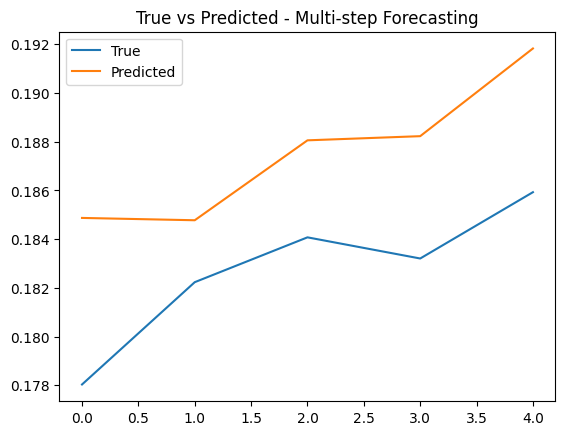

time: 253 ms (started: 2024-11-19 16:42:10 +00:00)


In [10]:
plt.plot(val_y[0], label='True')
plt.plot(y_pred[0], label='Predicted')
plt.legend()
plt.title('True vs Predicted - Multi-step Forecasting')
plt.show()

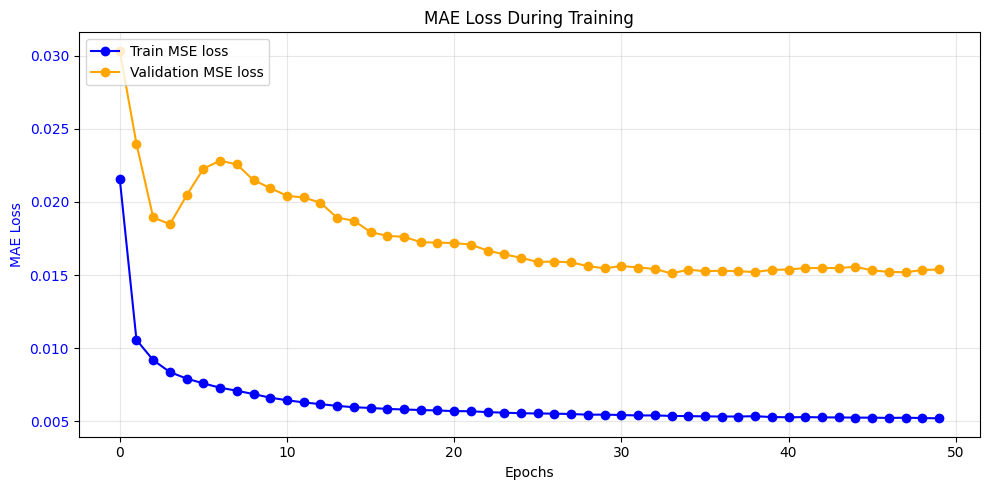

time: 324 ms (started: 2024-11-19 16:42:10 +00:00)


In [11]:
# Plotting
fig1, ax1 = plt.subplots(figsize=(10, 5))

# Loss plot
N = len(history.history["loss"])
epoch_range = np.arange(0, N)

ax1.plot(epoch_range, history.history["loss"], label='Train MSE loss', marker='o', color='blue')
ax1.plot(epoch_range, history.history["val_loss"], label='Validation MSE loss', marker='o', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MAE Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
plt.grid(True, alpha=0.3)
ax1.set_title('MAE Loss During Training')

# RMSE plot (shared x-axis, different y-axis)
# ax2 = ax1.twinx()
# fig2, ax2 = plt.subplots(figsize=(10, 5))
# ax2.plot(epoch_range, history.history["unscaled_mse"], label='Train MSE', color='green')
# ax2.plot(epoch_range, history.history["val_unscaled_mse"], label='Validation MSE', color='red')
# ax2.set_xlabel('Epochs')
# ax2.set_ylabel('Root Mean Squared Error (RMSE)', color='green')
# ax2.tick_params(axis='y', labelcolor='green')
# ax2.legend(loc='upper left')
# plt.grid(True, alpha=0.3)
# ax2.set_title('RMSE During Training')

plt.tight_layout()
plt.show()


Analyzing AAPL...

Evaluation Metrics for AAPL:
MSE: 71.1378
RMSE: 8.4343
MAE: 7.5684


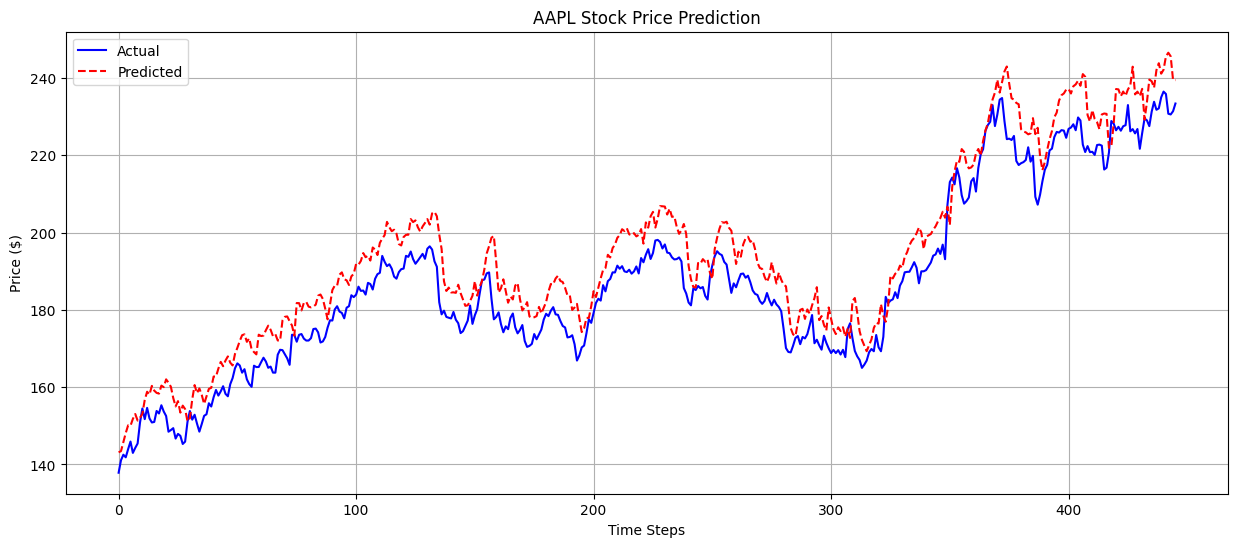


Analyzing AMZN...

Evaluation Metrics for AMZN:
MSE: 60.1943
RMSE: 7.7585
MAE: 6.8174


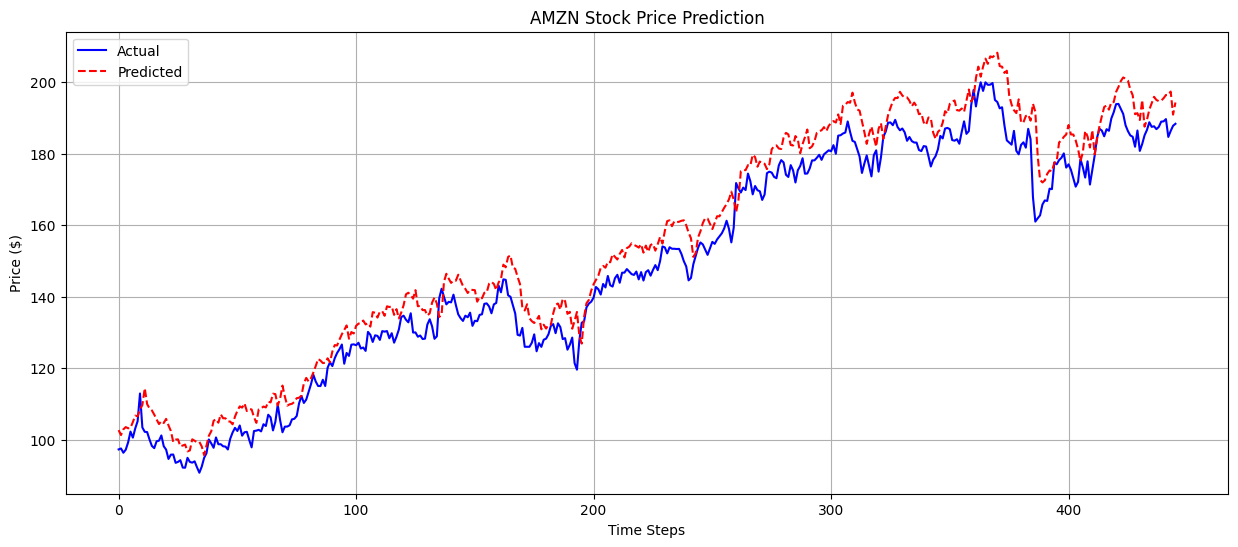


Analyzing GME...

Evaluation Metrics for GME:
MSE: 11.7278
RMSE: 3.4246
MAE: 2.6116


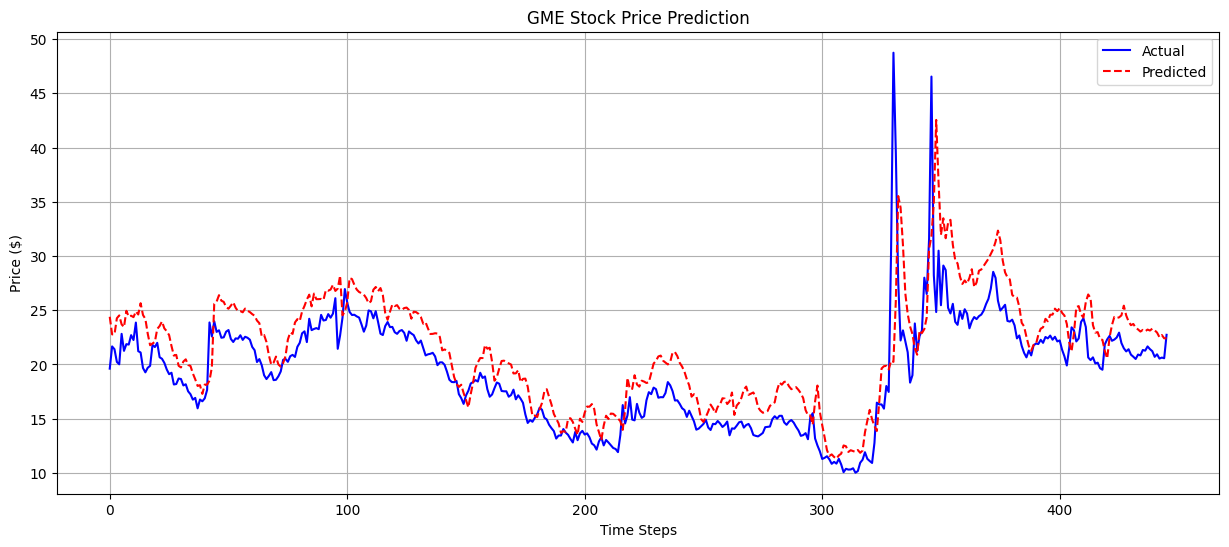


Analyzing GOOGL...

Evaluation Metrics for GOOGL:
MSE: 54.5272
RMSE: 7.3843
MAE: 6.4869


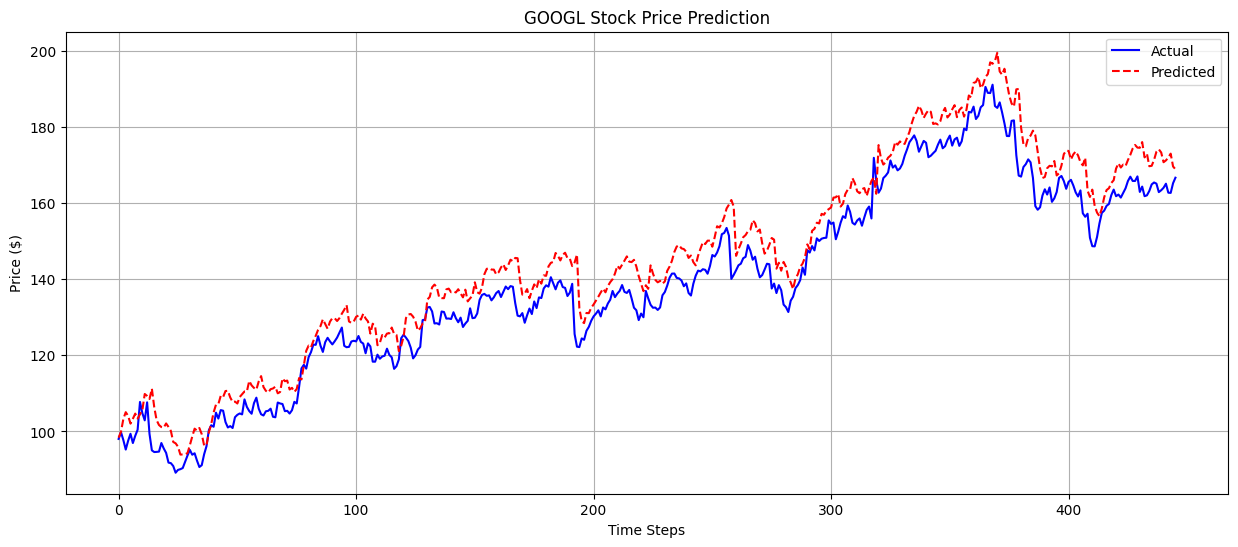


Analyzing NFLX...

Evaluation Metrics for NFLX:
MSE: 2101.2846
RMSE: 45.8398
MAE: 35.0768


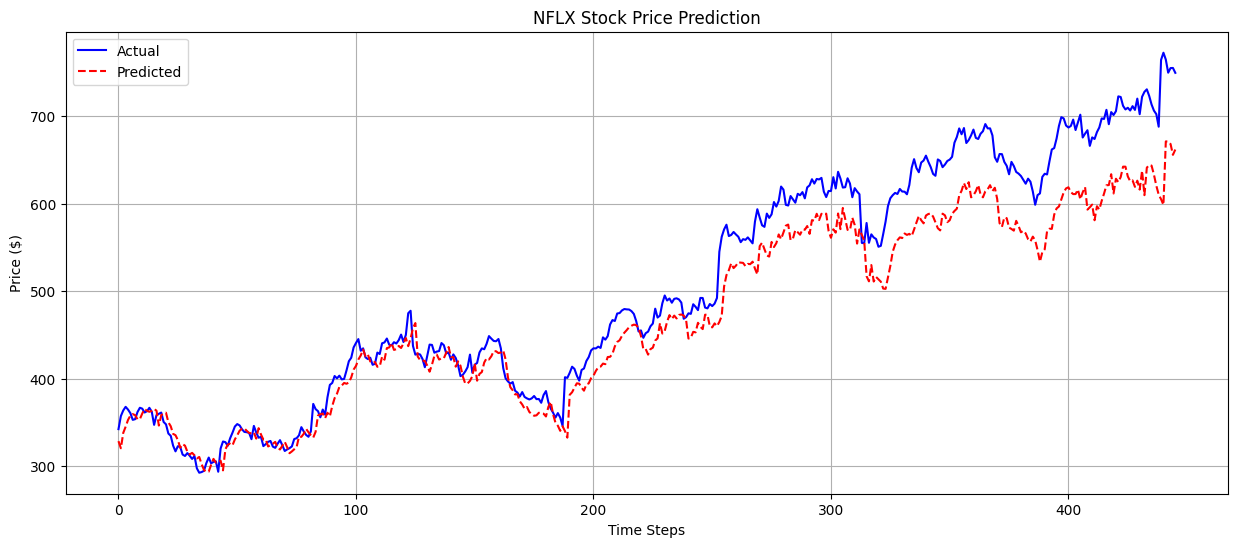


Analyzing TSLA...

Evaluation Metrics for TSLA:
MSE: 160.9419
RMSE: 12.6863
MAE: 9.9503


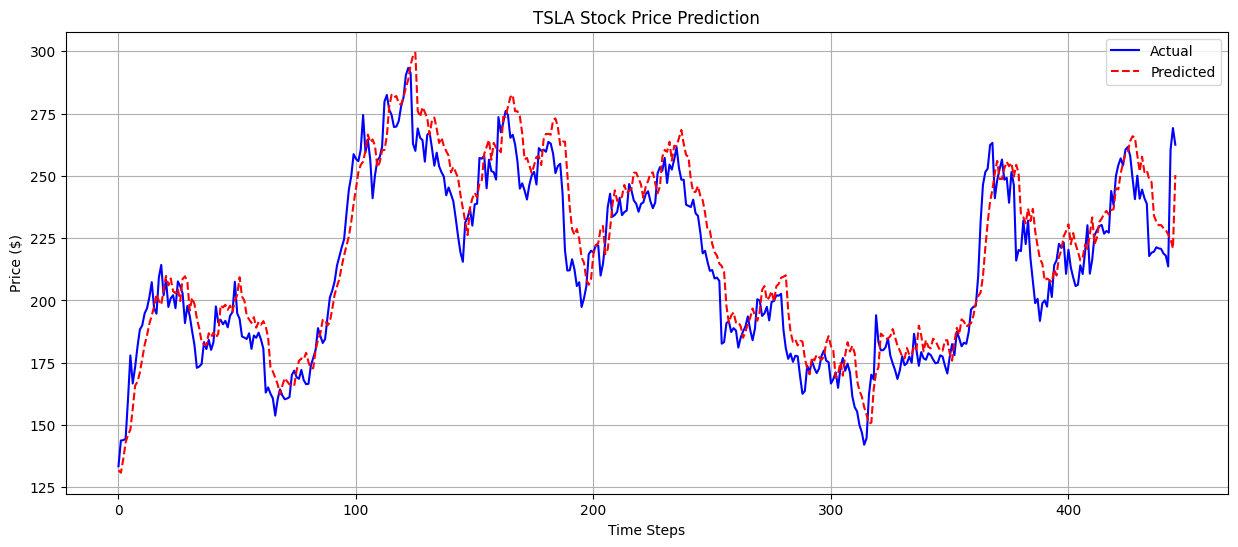


Analyzing MSFT...

Evaluation Metrics for MSFT:
MSE: 167.5424
RMSE: 12.9438
MAE: 10.1232


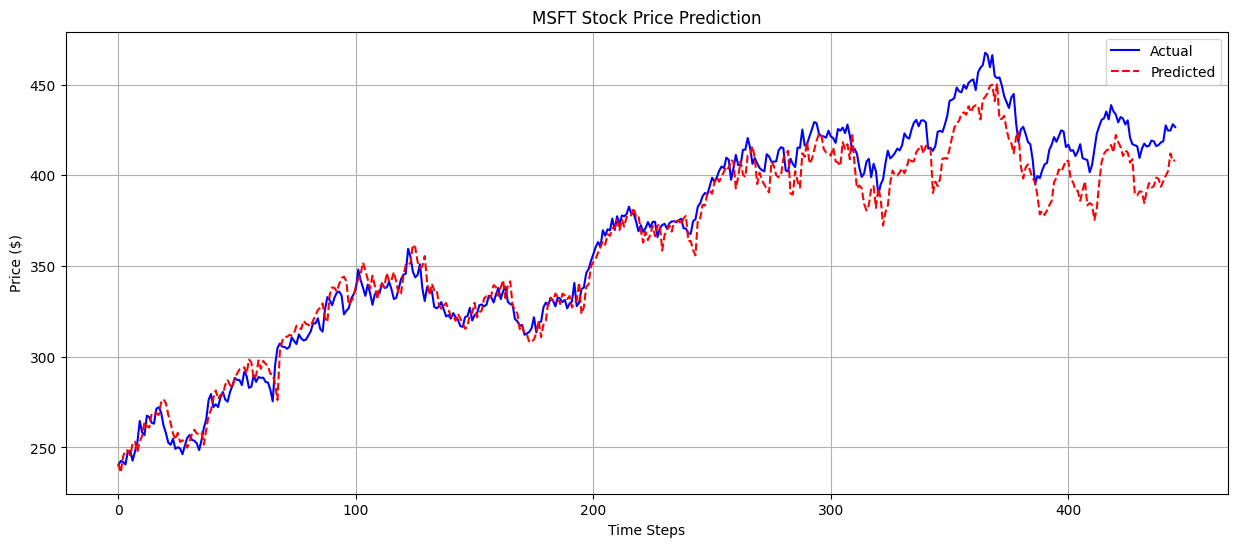


Analyzing NVDA...

Evaluation Metrics for NVDA:
MSE: 26.8838
RMSE: 5.1850
MAE: 3.9875


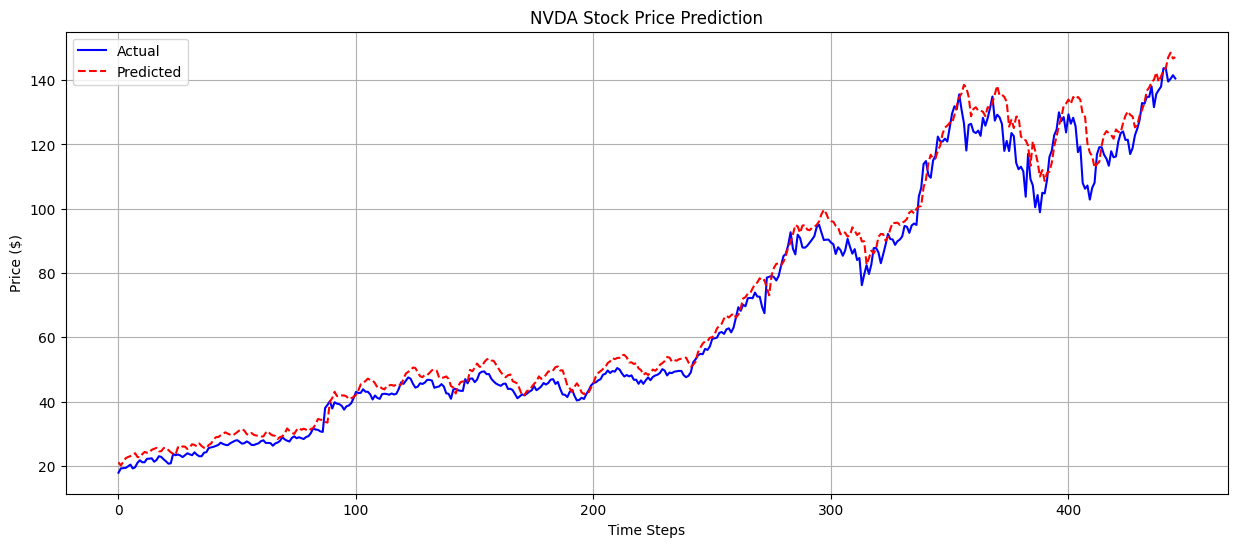


Analyzing AMD...

Evaluation Metrics for AMD:
MSE: 69.9578
RMSE: 8.3641
MAE: 6.7645


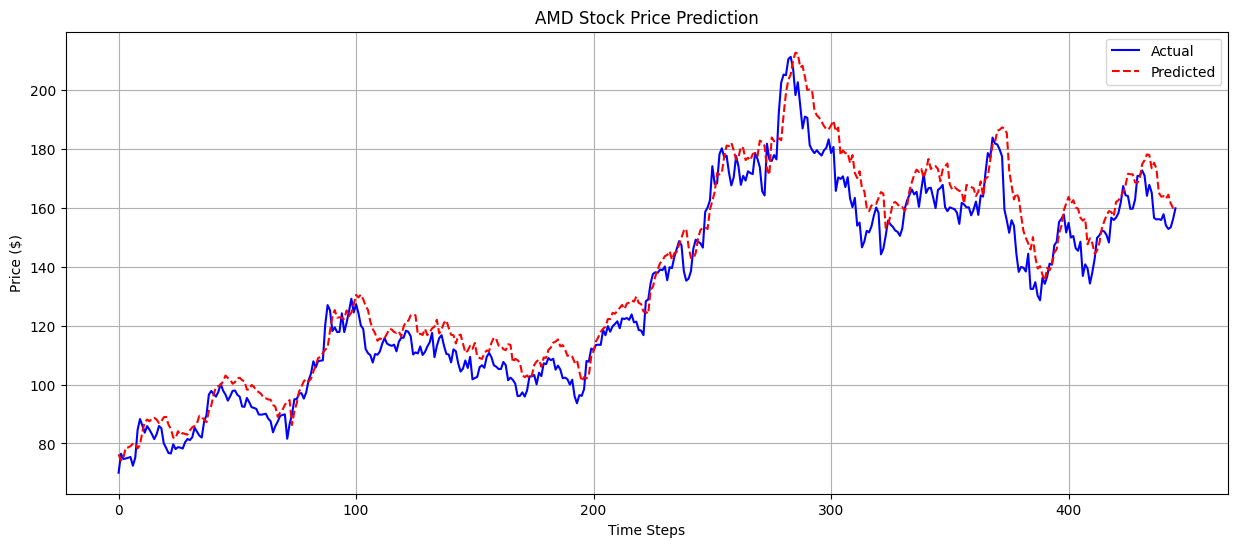


Analyzing CRM...

Evaluation Metrics for CRM:
MSE: 85.8323
RMSE: 9.2646
MAE: 7.3901


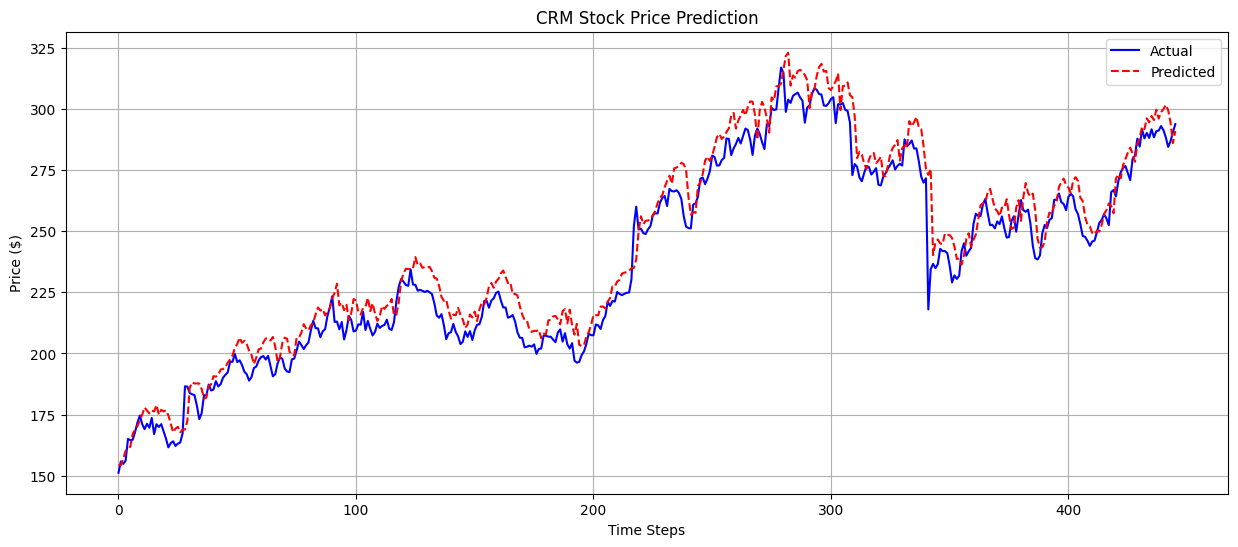


Analyzing JPM...

Evaluation Metrics for JPM:
MSE: 61.2535
RMSE: 7.8265
MAE: 7.1524


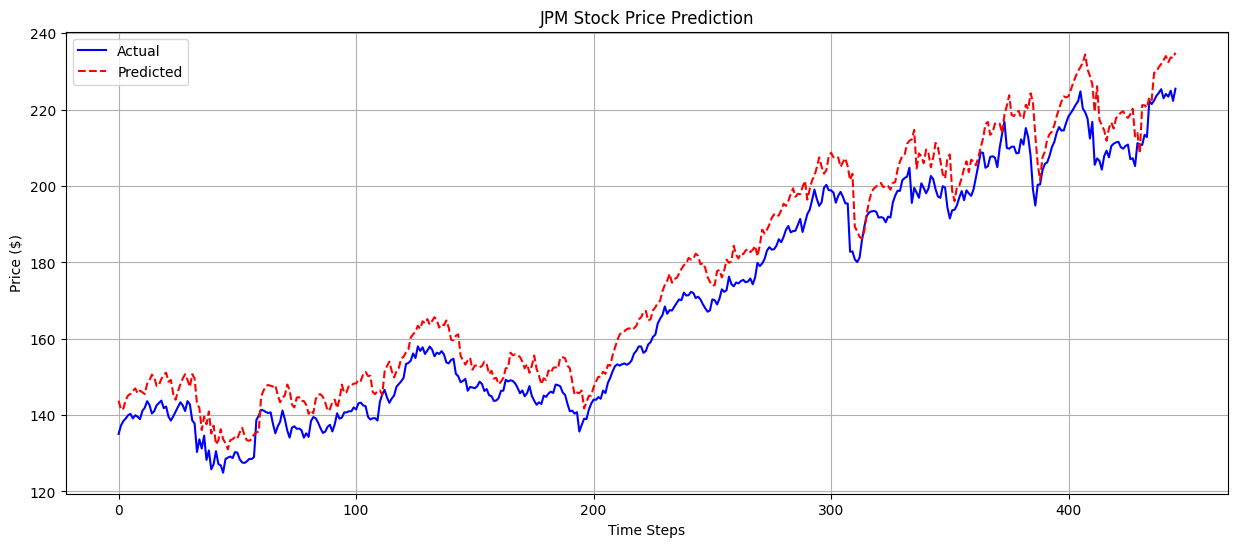


Analyzing V...

Evaluation Metrics for V:
MSE: 77.4637
RMSE: 8.8013
MAE: 7.6335


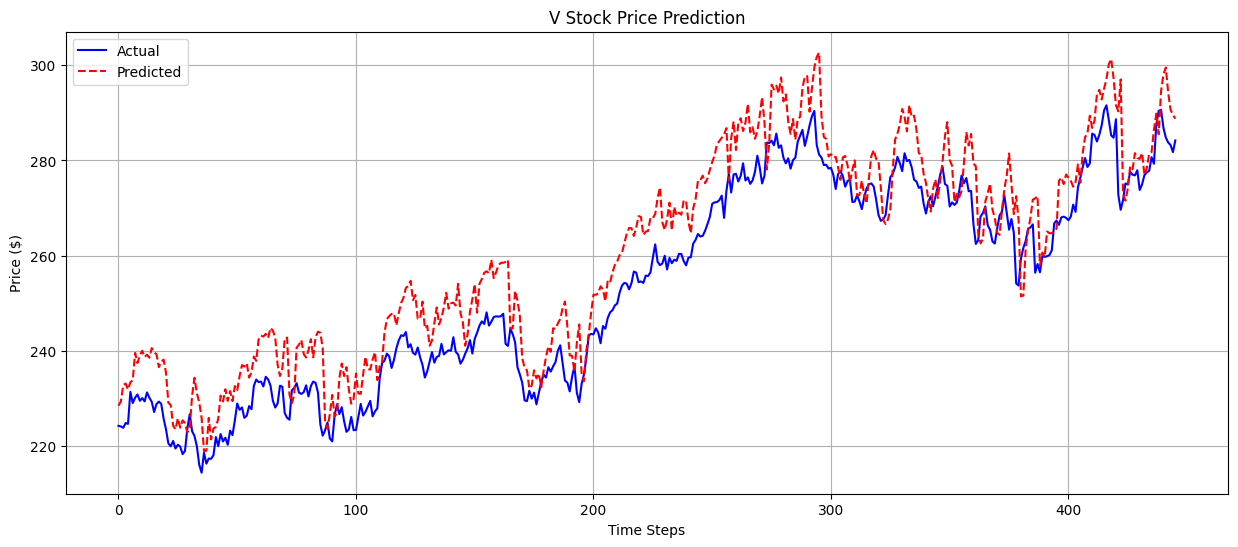


Analyzing MA...

Evaluation Metrics for MA:
MSE: 455.1287
RMSE: 21.3337
MAE: 18.2969


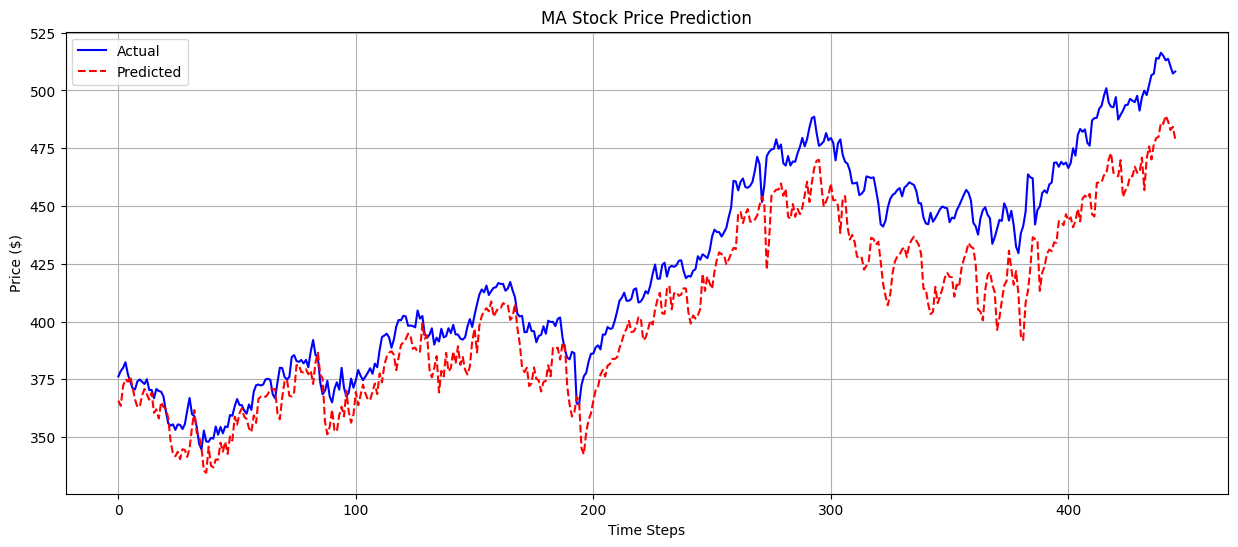


Analyzing MSTR...

Evaluation Metrics for MSTR:
MSE: 97.5800
RMSE: 9.8783
MAE: 6.3662


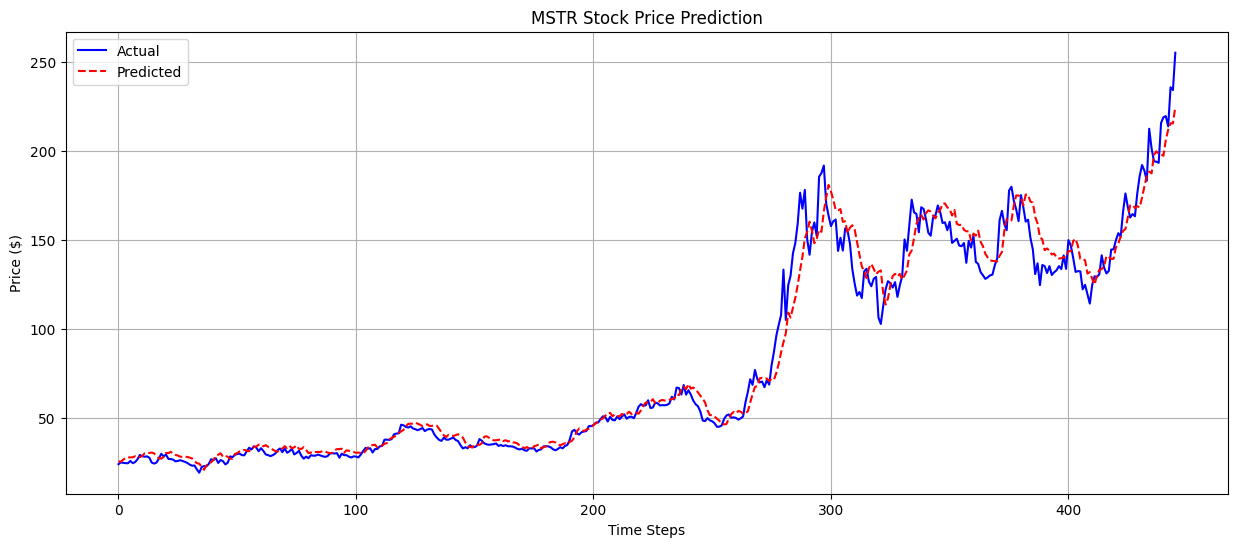


Analyzing DIS...

Evaluation Metrics for DIS:
MSE: 35.7894
RMSE: 5.9824
MAE: 5.4995


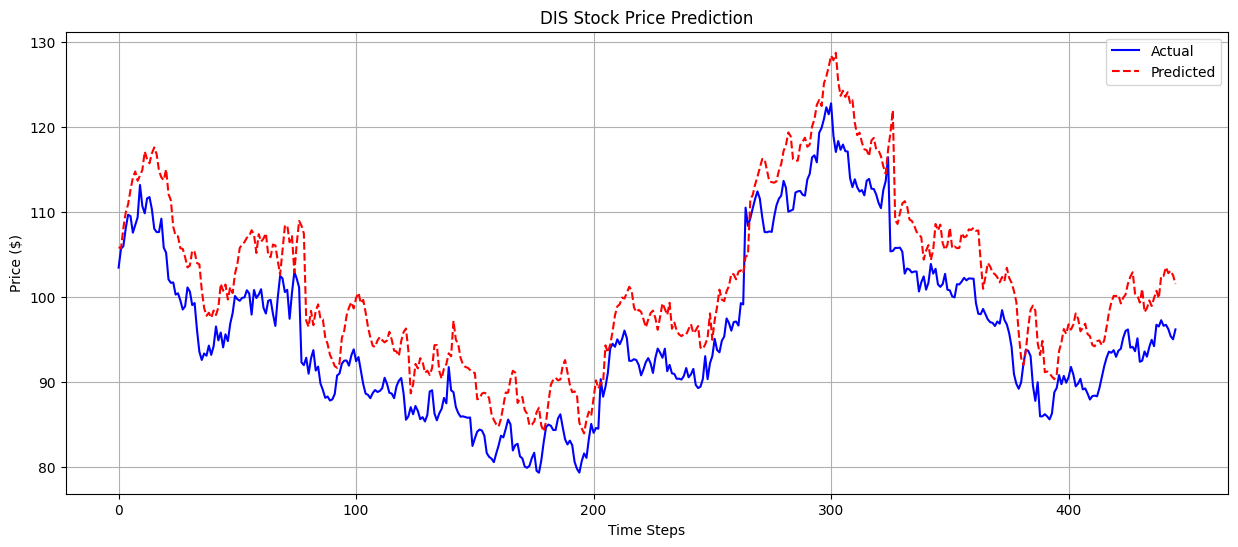


Analyzing BA...

Evaluation Metrics for BA:
MSE: 85.2050
RMSE: 9.2307
MAE: 7.6911


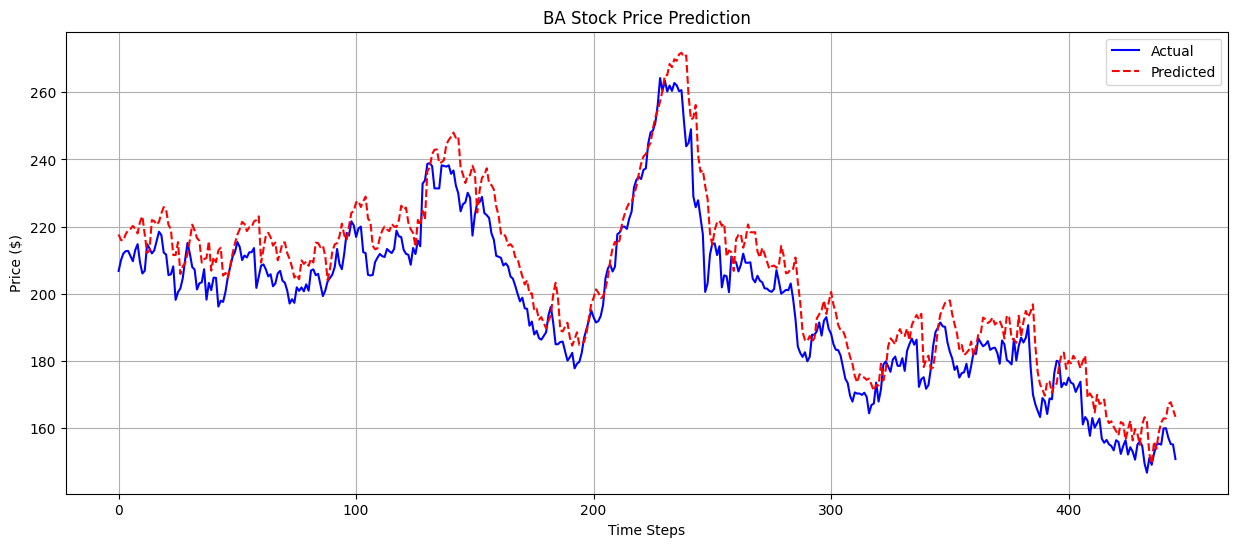


Analyzing XOM...

Evaluation Metrics for XOM:
MSE: 39.6018
RMSE: 6.2930
MAE: 5.8368


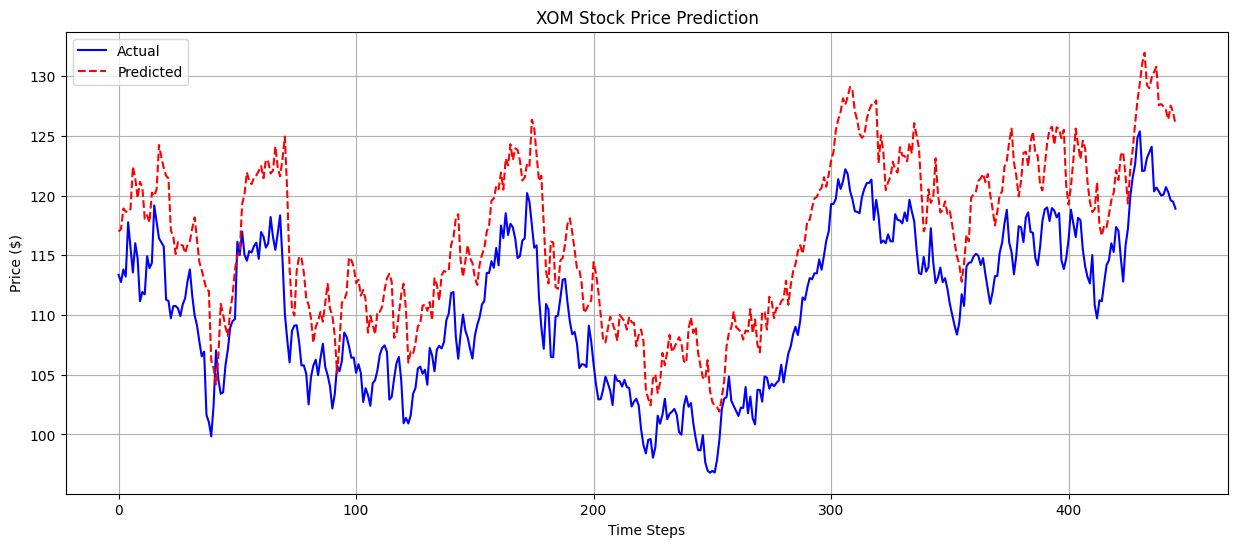


Analyzing ORCL...

Evaluation Metrics for ORCL:
MSE: 40.6259
RMSE: 6.3738
MAE: 5.6960


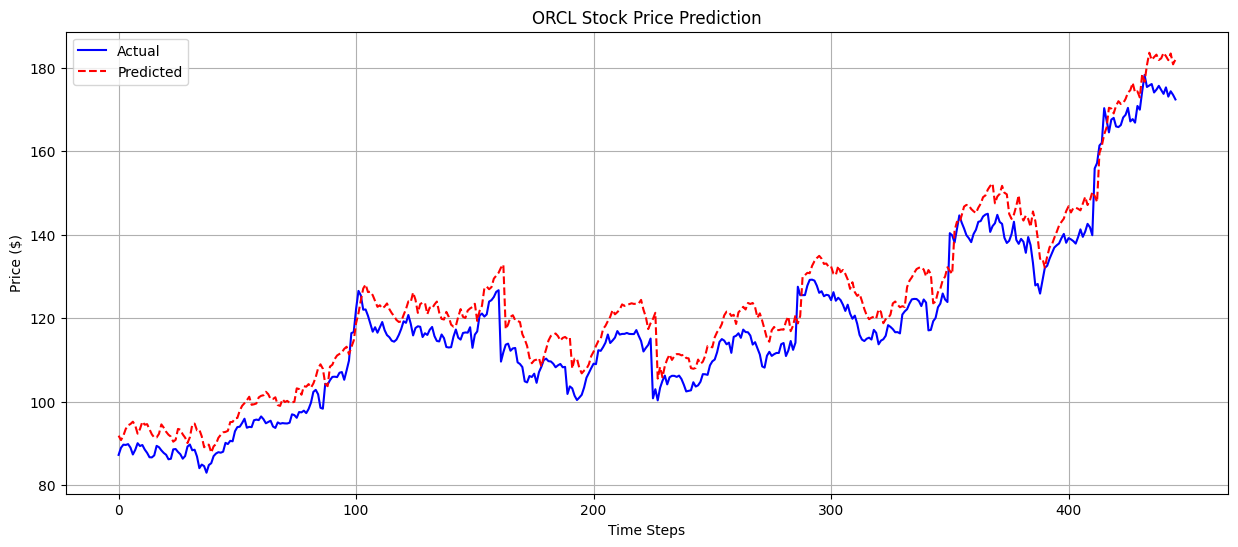


Analyzing META...

Evaluation Metrics for META:
MSE: 456.7722
RMSE: 21.3722
MAE: 15.6270


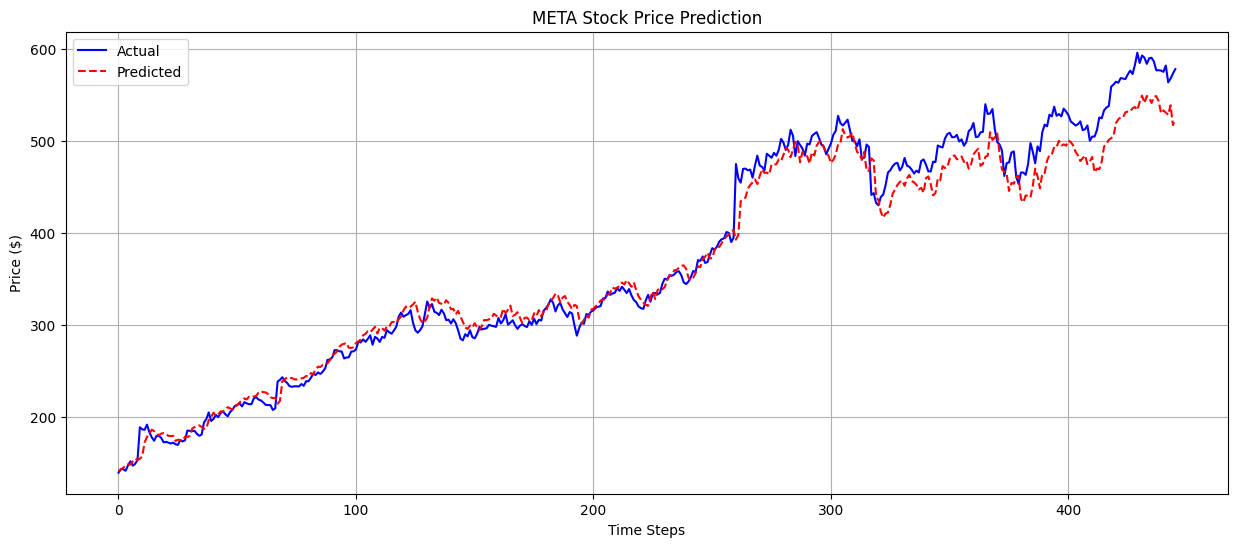


Summary of Metrics for All Stocks:
               MSE       RMSE        MAE
AAPL     71.137762   8.434320   7.568408
AMZN     60.194321   7.758500   6.817412
GME      11.727808   3.424589   2.611592
GOOGL    54.527191   7.384253   6.486878
NFLX   2101.284610  45.839771  35.076825
TSLA    160.941915  12.686288   9.950331
MSFT    167.542426  12.943818  10.123174
NVDA     26.883785   5.184958   3.987463
AMD      69.957808   8.364078   6.764472
CRM      85.832283   9.264571   7.390115
JPM      61.253525   7.826463   7.152403
V        77.463710   8.801347   7.633522
MA      455.128709  21.333746  18.296941
MSTR     97.580035   9.878261   6.366235
DIS      35.789359   5.982421   5.499458
BA       85.205041   9.230658   7.691146
XOM      39.601793   6.292996   5.836826
ORCL     40.625911   6.373846   5.695969
META    456.772187  21.372229  15.627046
time: 7.63 s (started: 2024-11-19 16:42:10 +00:00)


In [12]:
tickers = ['AAPL', 'AMZN', 'GME', 'GOOGL', 'NFLX', 'TSLA', 'MSFT', 'NVDA', 'AMD', 'CRM', 'JPM', 'V', 'MA', 'MSTR', 'DIS', 'BA', 'XOM', 'ORCL', 'META']

def split_validation_data(val_X, val_y, stock_lengths):
    """
    Split the combined validation data back into individual stocks.
    
    Args:
        val_X: Combined validation features
        val_y: Combined validation targets
        stock_lengths: List of number of validation samples for each stock
    """
    val_X_stocks = []
    val_y_stocks = []
    
    start_idx = 0
    for length in stock_lengths:
        val_X_stocks.append(val_X[start_idx:start_idx + length])
        val_y_stocks.append(val_y[start_idx:start_idx + length])
        start_idx += length
        
    return val_X_stocks, val_y_stocks

def inverse_transform_price(scaled_data, scaler):
    """
    Convert scaled prices back to actual prices
    """
    # Create a dummy array with zeros for all features
    dummy = np.zeros((len(scaled_data), scaler.scale_.shape[0]))
    # Put the scaled prices in the correct column (-1 is close price next day)
    dummy[:, -1] = scaled_data
    # Inverse transform
    inverse_transformed = scaler.inverse_transform(dummy)
    # Return only the close price column
    return inverse_transformed[:, -1]

def evaluate_predictions(y_true, y_pred, ticker, scaler):
    """
    Calculate and print evaluation metrics for the predictions
    """
    # Convert scaled values back to actual prices
    y_true_actual = inverse_transform_price(y_true, scaler)
    y_pred_actual = inverse_transform_price(y_pred, scaler)
    
    # Calculate metrics on actual prices
    mse = mean_squared_error(y_true_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_actual, y_pred_actual)
    
    print(f"\nEvaluation Metrics for {ticker}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return mse, rmse, mae

def plot_predictions(actual_values, predicted_values, ticker, scaler):
    """
    Plot actual vs predicted values in actual prices
    """
    plt.figure(figsize=(15, 6))
    
    # Convert to actual prices
    actual_prices = inverse_transform_price(actual_values, scaler)
    predicted_prices = inverse_transform_price(predicted_values, scaler)
    
    # Create time axis for plotting
    time_steps = range(len(actual_prices))
    
    # Plot
    plt.plot(time_steps, actual_prices, label='Actual', color='blue')
    plt.plot(time_steps, predicted_prices, label='Predicted', color='red', linestyle='--')
    
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate validation set lengths for each stock
def get_stock_val_lengths(values_list, train_split=0.8, n_steps_in=14, n_steps_out=5):
    """
    Calculate the number of validation samples for each stock
    """
    val_lengths = []
    for values in values_list:
        n_train = int(len(values) * train_split)
        val_data = values[n_train:]
        n_sequences = len(val_data) - n_steps_in - n_steps_out + 1
        if n_sequences > 0:
            val_lengths.append(n_sequences)
    return val_lengths

# Calculate validation lengths for each stock
val_lengths = get_stock_val_lengths(values_list)

# Split validation data back into individual stocks
val_X_stocks, val_y_stocks = split_validation_data(val_X, val_y, val_lengths)

# Make predictions for each stock
predictions_dict = {}
metrics_dict = {}

for i, ticker in enumerate(tickers):
    print(f"\nAnalyzing {ticker}...")
    
    # Get predictions for valid set
    val_predictions = model.predict(val_X_stocks[i], verbose=0)
    
    # Store predictions
    predictions_dict[ticker] = {
        'actual': val_y_stocks[i],
        'predicted': val_predictions
    }
    
    # Calculate metrics (using first day predictions)
    mse, rmse, mae = evaluate_predictions(
        val_y_stocks[i][:, 0],  # First day actual
        val_predictions[:, 0],   # First day predictions
        ticker,
        scaler
    )
    
    metrics_dict[ticker] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }
    
    # Plot predictions (first day)
    plot_predictions(
        val_y_stocks[i][:, 0],    # First day actual
        val_predictions[:, 0],     # First day predictions
        ticker,
        scaler
    )

# Create a summary DataFrame of metrics
metrics_df = pd.DataFrame(metrics_dict).T
print("\nSummary of Metrics for All Stocks:")
print(metrics_df)

In [13]:
def plot_future_predictions(historical_data, future_preds, actual_prices, ticker, scaler):
    """
    Plot historical data, future predictions, and actual prices in different colors
    
    Parameters:
    - historical_data: Historical price data
    - future_preds: Model's price predictions
    - actual_prices: Actual prices for the prediction period
    - ticker: Stock ticker symbol
    - scaler: The scaler used to transform the data
    """
    plt.figure(figsize=(15, 6))
    
    # Convert to actual prices
    historical_prices = inverse_transform_price(historical_data, scaler)
    future_prices = inverse_transform_price(future_preds.flatten(), scaler)
    actual_future_prices = inverse_transform_price(actual_prices.flatten(), scaler)
    
    # Plot historical data
    plt.plot(range(len(historical_prices)), historical_prices, label='Historical', color='blue')
    
    # Plot predictions
    connection_indices = range(len(historical_prices)-1, len(historical_prices) + len(future_prices))
    connection_points = np.concatenate([historical_prices[-1:], future_prices])
    plt.plot(connection_indices, connection_points, label='Predicted', color='red', linestyle='--')
    
    # Plot actual future prices (starting from the last historical point)
    actual_indices = range(len(historical_prices)-1, len(historical_prices) + len(actual_future_prices))
    actual_points = np.concatenate([historical_prices[-1:], actual_future_prices])
    plt.plot(actual_indices, actual_points, label='Actual', color='green', linewidth=2)
    
    plt.title(f'{ticker} Stock Price - Prediction vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()


def predict_future(model, last_sequence, n_steps_out, n_features):
    """
    Make future predictions using the last known sequence
    
    Args:
        model: trained LSTM model
        last_sequence: last known sequence of data (shape: [n_steps_in, n_features])
        n_steps_out: number of future steps to predict
        n_features: number of features in the input data
    """
    future_predictions = []
    current_sequence = last_sequence.reshape(1, n_steps_in, n_features)
    
    for _ in range(n_steps_out):
        # Get prediction for next step
        next_pred = model.predict(current_sequence, verbose=0)
        future_predictions.append(next_pred[0])
        
        # Update the sequence by removing the first timestep and adding the prediction
        # We'll repeat the last prediction across all features as an approximation
        new_row = np.repeat(next_pred[0][0], n_features).reshape(1, 1, n_features)
        current_sequence = np.concatenate([current_sequence[:, 1:, :], new_row], axis=1)
    
    return np.array(future_predictions)

# Future predictions
print("\nMaking Future Predictions...")
n_features = train_X.shape[2]

for i, ticker in enumerate(tickers):
    print(f"\nPredicting future prices for {ticker}...")
    
    # Get the last sequence from the validation data
    last_sequence = val_X[i][-1]
    
    # Make future predictions
    future_preds = predict_future(model, last_sequence, n_steps_out, n_features)
    
    # Get recent historical data for plotting (last 30 days)
    historical_data = val_y[i][-30:, 0]
    
    # Get actual future prices for comparison (next n_steps_out days)
    actual_future_prices = val_y[i][-n_steps_out:]
    
    # Print actual price predictions
    future_prices = inverse_transform_price(future_preds.flatten(), global_scaler)
    print(f"\n{ticker} - Next {n_steps_out} days price predictions:")
    for day, price in enumerate(future_prices, 1):
        print(f"Day {day}: ${price:.2f}")
        
    # Print actual prices for comparison
    actual_prices = inverse_transform_price(actual_future_prices.flatten(), global_scaler)
    print(f"\n{ticker} - Actual prices for comparison:")
    for day, price in enumerate(actual_prices, 1):
        print(f"Day {day}: ${price:.2f}")
        
    # Plot future predictions with historical context and actual prices
    try:
        plot_future_predictions(historical_data,future_preds,actual_future_prices,ticker,global_scaler)
    except Exception as e:
        print(f"Error plotting predictions for {ticker}: {e}")
        continue



Making Future Predictions...

Predicting future prices for AAPL...


ValueError: cannot reshape array of size 20 into shape (1,14,20)

time: 563 ms (started: 2024-11-19 16:42:18 +00:00)
